In [ ]:

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from data_handler import DataHandler
from forecast import Forecast

In [ ]:

start_of_data = datetime(2023, 11, 1)
end_of_training_data = datetime(2024, 1, 5)
dataHandler = DataHandler(
    "localhost",
    "smart_home_formankovi",
    "root",
    "root",
    "shelly1pm_34945475a969",
    start_of_data,
)






In [ ]:
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 4, 23, 59, 59)
data = dataHandler.get_data_for_prediction(forecast_begin_date, forecast_end_date)
data_train = dataHandler.get_data_for_training_model(start_of_data, end_of_training_data)

In [ ]:

#create a new dataframe from data[0] as columsn and data[1] as index
# data_longtime = data[0].set_index(data[1])
# data_longtime = data_longtime.resample('30T').sum()
data_longtime = data_train[0].set_index(data_train[1])
data_longtime = data_longtime.resample('30T').sum()
print(data_longtime)
plt.plot(data_longtime['longtime_mean'])

In [ ]:

forecast = Forecast(dataHandler)
forecast.train_model(begin_of_training=start_of_data, end_of_training=end_of_training_data)
forecast.build_model()
forecast.fit_model()




In [ ]:
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 4, 23, 59, 59)
pred = forecast.get_forecast_next_steps(start_of_data, end_of_training_data)



In [ ]:
prediction = pred[0]
truth = pred[1]
prediction = prediction / 100
truth = truth / 100
plt.plot(prediction, label="Predicted")
plt.plot(truth, label="Truth")

In [ ]:
# create dataframe with column datetime from now to now+6hours and rows by 30 minutes

forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 4, 23, 59, 59)

df_predict = pd.DataFrame({'datetime': pd.date_range(forecast_begin_date, forecast_end_date, freq='30min')})
df_predict['longtime_mean'] = 0
df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# delete column datetime
df_predict = df_predict.drop(columns='datetime')
df_predict_trans = df_predict.copy()
df_predict_trans[df_predict.columns] = forecast.scaler.transform(df_predict)

predict_gen = forecast.generator(df_predict_trans, 'longtime_mean', 
                lookback = forecast.lookback,
                delay = forecast.delay,
                min_index = 0,
                max_index = None,
                step = 1,
                shuffle = False,
                batch_size = df_predict.shape[0])

(X_2, y_2) = next(predict_gen)
print((X_2.shape))
y_pred_2 = forecast.model.predict(X_2)
y_pred_2_inv = np.concatenate((y_pred_2,np.zeros((y_pred_2.shape[0],forecast.num_of_features))),axis=1)
y_pred_2_inv = forecast.scaler.inverse_transform(y_pred_2_inv)
y_pred_2_inv = y_pred_2_inv[:,0]

plt.plot(y_pred_2_inv, color = 'green', label = 'Predicted data')
plt.plot(y_2, color = 'green', label = 'Predicted data')
plt.show()

In [ ]:
# create a df with datetime and predicted values
df_predicted = pd.DataFrame()
df_predicted['longtime_mean'] = y_pred_2
print(len(y_pred_2))
forecast_begin_date = forecast_begin_date + pd.Timedelta(5, unit='h')
x = pd.date_range(forecast_begin_date , forecast_end_date, freq='30min')
print(x.shape)
df_predicted['datetime'] = pd.date_range(forecast_begin_date , forecast_end_date, freq='30min')

In [ ]:
queries = {
            "water_flow": {
                "sql_query": f'SELECT mean("value") AS "water_flow_L_per_hour_mean" FROM "smart_home_formankovi"."autogen"."L/min" WHERE "entity_id"=\'esphome_boiler_temps_current_water_usage\' GROUP BY time(5s) FILL(0)',
                "measurement": "L/min",
            },
            "water_temperature": {
                "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_formankovi"."autogen"."°C" WHERE "entity_id"=\'esphome_boiler_temps_ntc_temperature_b_constant\' GROUP BY time(5s) FILL(previous)',
                "measurement": "°C",},
            "boiler_wattage": {
                "sql_query": f'SELECT mean("value") AS "boiler_wattage_mean" FROM "smart_home_formankovi"."autogen"."W" WHERE "entity_id"=\'shelly1pm_34945475a969_power\' GROUP BY time(5s) FILL(0)',
                "measurement": "W",
            },
            }
            # "boiler_relay_status": {"sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "smart_home_formankovi"."autogen"."state" WHERE time > {time_interval_left} AND time < {time_interval_right} AND "entity_id"=\'{self.relay_entity_id}\' GROUP BY time(1h) FILL(previous)',
            #                        "measurement": "state"},
        
from influxdb import DataFrameClient
dataframe_client = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi'
        )

df_all_list = []
# iterate over key an value in data_formankovi
for key, value in queries.items():
    # get data from influxdb
    result = dataframe_client.query(value["sql_query"])[
        value["measurement"]
    ]
    
    df = pd.DataFrame(result)
    df_all_list.append(df)
        


In [ ]:
df = pd.concat(df_all_list, axis=1)
df = df[['water_flow_L_per_hour_mean', 'water_temperature_mean', 'boiler_wattage_mean']]
print(df.head())

In [ ]:
df = pd.concat(df_all_list, axis=1)
df = df[['water_flow_L_per_hour_mean', 'water_temperature_mean', 'boiler_wattage_mean']]
df['water_flow_L_per_hour_mean'] = df['water_flow_L_per_hour_mean']

df[f"consumed_heat_kJ"] = (
            df[f"water_flow_L_per_hour_mean"]
            * (df[f"water_temperature_mean"] - 10)
            * 4.186
            *0.6
            
        )
df = df.resample('1min').mean()
df['liter_cum_sum'] = df['water_flow_L_per_hour_mean'].cumsum()

df = df.groupby(pd.Grouper(freq='7D'))
df = df.agg({'consumed_heat_kJ': 'sum', 'water_flow_L_per_hour_mean': 'mean', 'water_temperature_mean': 'mean', 'boiler_wattage_mean': 'sum'})
        
# df consumed_heat_kJ to kWh
df[f"consumed_heat_kWh"] = df[f"consumed_heat_kJ"] / (3600)
df[f"consumed_heat_kWh"] += 0.4*7
df[f"boiler_wattage_kWh"] = df[f"boiler_wattage_mean"] / (1000*60)

df['heat_loss'] = df['consumed_heat_kWh'] - df['boiler_wattage_kWh']

plt.plot( df['boiler_wattage_kWh'], label="consumed_heat_kWh")
plt.plot( df['consumed_heat_kWh'], label="consumed_heat_kWh")
plt.legend()



In [ ]:

from pytz import utc
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_training_data = datetime(2024, 1, 5)
dataHandler = DataHandler(
    "localhost",
    "smart_home_formankovi",
    "root",
    "root",
    "shelly1pm_34945475a969",
    start_of_data,
)

forecast = Forecast(dataHandler)
forecast.train_model(begin_of_training=start_of_data, end_of_training=end_of_training_data)
forecast.build_model()
forecast.fit_model()





-----
1/1 [==============================] - 0s 10ms/step
-----
    longtime_mean  weekday_sin  weekday_cos      hour_sin      hour_cos  \
0        2.604167    -0.781831      0.62349  7.071068e-01  7.071068e-01   
1        2.604167    -0.781831      0.62349  8.660254e-01  5.000000e-01   
2        2.604167    -0.781831      0.62349  8.660254e-01  5.000000e-01   
3        2.640365    -0.781831      0.62349  9.659258e-01  2.588190e-01   
4        2.640365    -0.781831      0.62349  9.659258e-01  2.588190e-01   
5        2.749901    -0.781831      0.62349  1.000000e+00  6.123234e-17   
6        4.011862    -0.781831      0.62349  1.000000e+00  6.123234e-17   
7        4.011862    -0.781831      0.62349  9.659258e-01 -2.588190e-01   
8        4.049779    -0.781831      0.62349  9.659258e-01 -2.588190e-01   
9        8.882114    -0.781831      0.62349  8.660254e-01 -5.000000e-01   
10      10.856915    -0.781831      0.62349  8.660254e-01 -5.000000e-01   
11      10.747380    -0.781831      

/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [===

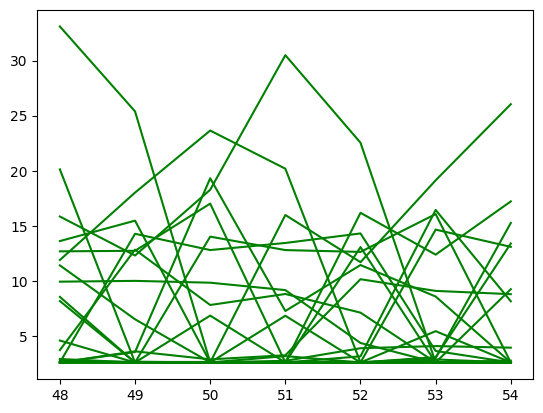

In [124]:
from operator import le
import pandas as pd
import numpy as np
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 1, 23, 59, 59)

queries = dataHandler.get_database_queries(left_time_interval=forecast_begin_date - timedelta(days=1), right_time_interval=forecast_begin_date)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)

# remove information about tz
df_all.index = df_all.index.tz_localize(None)

# iterate from forecast_begin_date to forecast_end_date in intervals of 6*30 minutes
# create a df with datetime and predicted values
# predict the values for the next 6*30 minutes
# concar df_all and df_predict
# move in time by 6*30 minutes
# repeat

df_all, _= dataHandler.transform_data_for_ml(df_all, predicted_column='longtime_mean')

forecast_future = df_all.copy()

current_forecast_begin_date = forecast_begin_date
current_forecast_end_date = forecast_begin_date + timedelta(hours=3)
for i in range(0, 24):
    print("-----")

    df_predict = pd.DataFrame({'datetime': pd.date_range(current_forecast_begin_date, current_forecast_end_date, freq='30min')})
    df_predict['longtime_mean'] = 0
    df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
    df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
    df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
    df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
    df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
    df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
    # delete column datetime
    df_predict = df_predict.drop(columns='datetime')
    len_df_predict = df_predict.shape[0]
    
    
    # concar df_all and df_predict
    
    df_all = pd.concat([df_all, df_predict], axis=0)
    # reindex df_all
    df_all = df_all.reset_index(drop=True)
    if(i == 1):
        print(df_all)
    
    

    df_predict_norm = df_all.copy()
    df_predict_norm[df_all.columns] = forecast.scaler.transform(df_all)
    # create predict df with values 

    predict_gen = forecast.generator(dataframe = df_predict_norm, 
            target_name = forecast.predicted_column, 
            lookback = forecast.lookback,
            delay = forecast.delay,
            min_index = 0,
            max_index = None,
            step = 1,
            shuffle = False,
            batch_size = df_predict.shape[0])

    (X, y_truth) = next(predict_gen)

    y_pred = forecast.model.predict(X)

    # np.expand_dims(y_truth,axis=1).shape
    y_pred_inv = np.concatenate((y_pred,np.zeros((y_pred.shape[0],forecast.num_of_features))),axis=1)
    y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
    y_pred_inv = y_pred_inv[:,0]
    # set df_all last len_df_predict values to y_pred_inv
    df_all.iloc[-len_df_predict:, df_all.columns.get_loc('longtime_mean')] = y_pred_inv
    plt.plot(df_all.iloc[-len_df_predict:, df_all.columns.get_loc('longtime_mean')], color = 'green', label = 'Predicted data')
    df_all = df_all[len_df_predict:]
    forecast_future = pd.concat([forecast_future, df_all[-len_df_predict:]], axis=0)
    forecast_future = forecast_future.reset_index(drop=True)
    
    current_forecast_begin_date = current_forecast_begin_date + timedelta(hours=3)
    current_forecast_end_date = current_forecast_end_date + timedelta(hours=3)

# df_predict = pd.DataFrame({'datetime': pd.date_range(forecast_begin_date, forecast_end_date, freq='30min')})
# df_predict['longtime_mean'] = 0
# df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
# df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
# df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
# df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
# df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# # delete column datetime
# df_predict = df_predict.set_index('datetime')
# # concar df_all and df_predict
# df_all = pd.concat([df_all, df_predict], axis=0)

In [125]:
print (forecast_future.index)


RangeIndex(start=0, stop=216, step=1)


In [126]:
print(forecast_future['longtime_mean'])

0       2.604167
1       2.604167
2       2.604167
3       2.604167
4       2.604167
         ...    
211    19.320556
212     7.275624
213    11.444964
214     8.588853
215     2.604701
Name: longtime_mean, Length: 216, dtype: float64


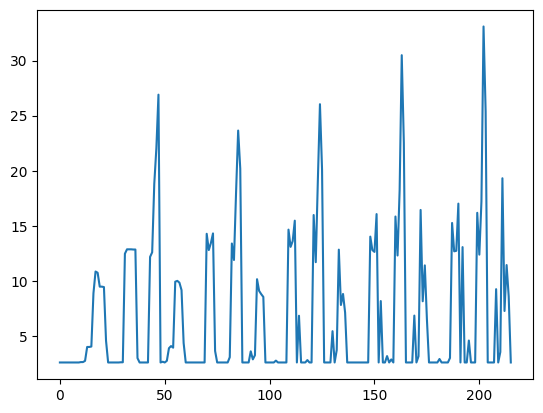

In [127]:
# plt.plot(forecast_future['consumed_heat_kWh'], label="Predicted")
plt.plot(forecast_future['longtime_mean'], label="Truth")

begin = datetime(2024, 1, 1, 0, 0, 0) 
end = datetime(2024, 1, 1, 23, 59, 59)

queries = dataHandler.get_database_queries(left_time_interval=forecast_begin_date - timedelta(days=1), right_time_interval=forecast_begin_date)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)

In [128]:

df_all, _= dataHandler.transform_data_for_ml(df_all, predicted_column='longtime_mean')



/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [129]:
from sklearn.metrics import mean_squared_error
from scipy import stats

df_predict_norm = df_all.copy()
df_predict_norm[df_predict.columns] = forecast.scaler.transform(df_all)
# create predict df with values 

predict_gen = forecast.generator(dataframe = df_predict_norm, 
        target_name = forecast.predicted_column, 
        lookback = forecast.lookback,
        delay = forecast.delay,
        min_index = 0,
        max_index = None,
        step = 1,
        shuffle = False,
        batch_size = df_predict.shape[0])

(X, y_truth) = next(predict_gen)

y_pred = forecast.model.predict(X)

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate((y_pred,np.zeros((y_pred.shape[0],forecast.num_of_features))),axis=1)
y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:,0]

y_truth_inv = np.concatenate((np.expand_dims(y_truth,axis=1),np.zeros((y_truth.shape[0],forecast.num_of_features))),axis=1)
y_truth_inv = forecast.scaler.inverse_transform(y_truth_inv)
y_truth_inv = y_truth_inv[:,0]

statistics = {}
slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv,y=y_truth_inv)
mse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=True)
rmse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=False)

statistics['slope'] = slope
statistics['intercept'] = intercept
statistics['r_value'] = r_value
statistics['p_value'] = p_value
statistics['std_err'] = std_err
statistics['mse'] = mse
statistics['rmse'] = rmse




1/1 [==============================] - 0s 11ms/step


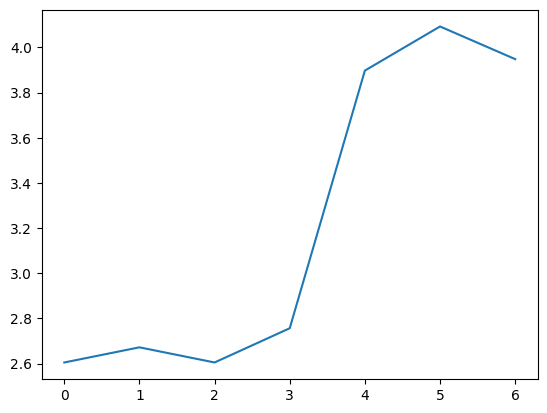

In [130]:
import matplotlib.pyplot as plt
plt.plot(y_pred_inv, label="Predicted")